<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install nltk

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import collections

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [20]:
def month_to_number(month):
  months = {"january": "1", "february": "2", "march": "3", "april": "4", "may": "5", "june": "6", "july": "7", \
            "august": "8", "september": "9", "october": "10", "november": "11", "december": "12"}
  month = month.lower()
  numerical = months[month]
  return numerical

def to_date(string):
  elements = string.split(',')
  year = elements[-1].strip()
  month, day = elements[-2].split()
  month = month_to_number(month)
  date = f'{year}-{month}-{day}'
  return date

(array([1., 2., 4., 3., 4., 1., 2., 1., 2., 3.]),
 array([16785., 17049., 17313., 17577., 17841., 18105., 18369., 18633.,
        18897., 19161., 19425.]),
 <BarContainer object of 10 artists>)

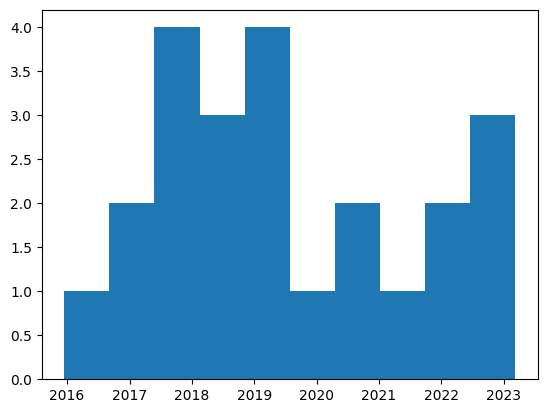

In [21]:
df = pd.read_excel('https://github.com/yuliiabosher/Adam_Smith_project/raw/main/adam_smith.xlsx', skiprows=1)
df = df.fillna('n/a')
df = df.drop(df[df['Mention of Adam smith'].str.contains('NA')].index)
df = df.drop(df[df['Mention of Adam smith'].str.contains('n/a')].index)
df.columns = ['Date', 'Extract', 'Notes', 'Notes2', 'About Adam Smith', 'Rep']
dates = []
for index, row in df.iterrows():
  dates.append(to_date(row['Date']))
df['Date'] = dates
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()
plt.hist(df.index)


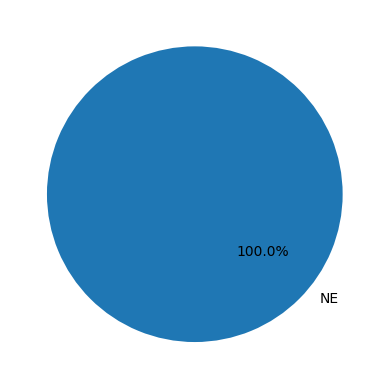

In [39]:
ner_categories = collections.defaultdict(int)
for index, row in df.iterrows():
  sentences = nltk.sent_tokenize(row['Extract'])
  token_sentences = [nltk.word_tokenize(sent) for sent in sentences]
  pos_sentences = [nltk.pos_tag(sent) for sent in token_sentences]
  chunked_sentences = nltk.ne_chunk_sents(pos_sentences, binary=True)
  for sent in chunked_sentences:
    for chunk in sent:
      if hasattr(chunk, 'label'):
        ner_categories[chunk.label()] += 1

labels = list(ner_categories.keys())
values = [ner_categories.get(v) for v in labels]
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.show()
